In [1]:
from PIL import Image
import os, sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio
import tensorflow as tf


# defining the canny detector function

# here weak_th and strong_th are thresholds for
# double thresholding step
def cfa_preprocessing(img, weak_th = None, strong_th = None):
	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# Noise reduction step
	img = cv2.GaussianBlur(img, (5, 5), 1.4)
	# Calculating the gradients
	gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
	gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
	# Conversion of Cartesian coordinates to polar
	mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
	# setting the minimum and maximum thresholds
	# for double thresholding
	mag_max = np.max(mag)
	if not weak_th:weak_th = mag_max * 0.1
	if not strong_th:strong_th = mag_max * 0.5
	# getting the dimensions of the input image
	height, width = img.shape
	# Looping through every pixel of the grayscale
	# image
	for i_x in range(width):
		for i_y in range(height):
			
			grad_ang = ang[i_y, i_x]
			grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
			
			# selecting the neighbours of the target pixel
			# according to the gradient direction
			# In the x axis direction
			if grad_ang<= 22.5:
				neighb_1_x, neighb_1_y = i_x-1, i_y
				neighb_2_x, neighb_2_y = i_x + 1, i_y
			
			# top right (diagonal-1) direction
			elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
				neighb_1_x, neighb_1_y = i_x-1, i_y-1
				neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
			
			# In y-axis direction
			elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
				neighb_1_x, neighb_1_y = i_x, i_y-1
				neighb_2_x, neighb_2_y = i_x, i_y + 1
			
			# top left (diagonal-2) direction
			elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
				neighb_1_x, neighb_1_y = i_x-1, i_y + 1
				neighb_2_x, neighb_2_y = i_x + 1, i_y-1
			
			# Now it restarts the cycle
			elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
				neighb_1_x, neighb_1_y = i_x-1, i_y
				neighb_2_x, neighb_2_y = i_x + 1, i_y
			
			# Non-maximum suppression step
			if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
				if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
					mag[i_y, i_x]= 0
					continue

			if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
				if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
					mag[i_y, i_x]= 0

	weak_ids = np.zeros_like(img)
	strong_ids = np.zeros_like(img)			
	ids = np.zeros_like(img)
	
	# double thresholding step
	for i_x in range(width):
		for i_y in range(height):
			
			grad_mag = mag[i_y, i_x]
			
			if grad_mag<weak_th:
				mag[i_y, i_x]= 0
			elif strong_th>grad_mag>= weak_th:
				ids[i_y, i_x]= 1
			else:
				ids[i_y, i_x]= 2
	
# morphological dialation
	kernel = np.ones((5,5), np.uint8)
	img_erosion= cv2.dilate(mag, kernel, iterations=1)
# noise removal

    
	blur = cv2.blur(img_erosion,(5,5))  
    
	# finally returning the magnitude of
	# gradients of edges
	return blur


In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob


In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'project'
valid_path = 'projecttest'

In [4]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [6]:
  # useful for getting number of output classes
folders = glob('project/*')

In [7]:
folders

['project\\cha',
 'project\\gha',
 'project\\nga']

In [8]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [9]:
len(folders)

3

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('project',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 380 images belonging to 3 classes.


In [15]:
test_set = test_datagen.flow_from_directory('projecttest',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 73 images belonging to 3 classes.


In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

C:\Users\hp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
12/12 [==============================] - 88s 7s/step - loss: 0.8536 - accuracy: 0.7211 - val_loss: 0.5547 - val_accuracy: 0.7397
Epoch 2/5
12/12 [==============================] - 86s 7s/step - loss: 0.1522 - accuracy: 0.9447 - val_loss: 0.1594 - val_accuracy: 0.9315
Epoch 3/5
12/12 [==============================] - 87s 7s/step - loss: 0.0739 - accuracy: 0.9868 - val_loss: 0.0914 - val_accuracy: 0.9589
Epoch 4/5
12/12 [==============================] - 87s 7s/step - loss: 0.0375 - accuracy: 0.9895 - val_loss: 0.2298 - val_accuracy: 0.9041
Epoch 5/5
12/12 [==============================] - 79s 7s/step - loss: 0.0192 - accuracy: 0.9947 - val_loss: 0.1012 - val_accuracy: 0.9452


In [17]:
import matplotlib.pyplot as plt

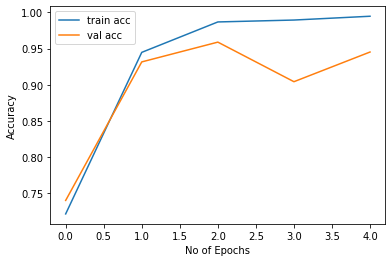

<Figure size 432x288 with 0 Axes>

In [18]:
# save it as a h5 file


from tensorflow.keras.models import load_model
model.save('model_vgg16.h5')


# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [2]:
from tensorflow.keras.models import load_model
model=load_model('model_vgg16.h5')

In [54]:
#REAL TIME
import cv2
import time

cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        cv2.imwrite('final/acaf.jpg',frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()
time.sleep(4)

opencv_frame_0.png written!
Escape hit, closing...


In [55]:
image = cv2.imread('final/acaf.jpg')
canny_image= cfa_preprocessing(image)
cv2.imwrite('final/acafi.jpg',canny_image)


True

In [56]:
# importing Image class from PIL package
import cv2
 
import numpy as np
from keras.preprocessing import image
test_image=image.load_img('final/acafi.jpg',target_size=(224,224))
# test_image=cv2.imread('final_image/acf.jpg')
test_image=image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
# train_generator.class_indices
cha=result[0][0]
gha=result[0][1]
nga=result[0][2]
  
largest = 0

if cha > gha and cha > nga:
    prediction = 'cha'
if gha > cha and gha > nga:
    prediction = 'gha'
if nga > cha and nga > gha:
    prediction = 'nga'


In [57]:
prediction

'nga'

In [58]:
result

array([[0., 0., 1.]], dtype=float32)

Text(0.5, 1.0, 'Predicted_image')

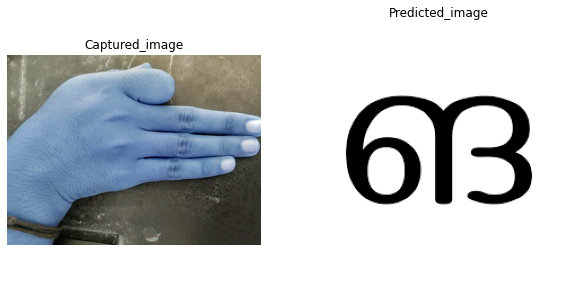

In [59]:

from matplotlib import pyplot as plt
if prediction=='cha':
    img = cv2.imread('pre_final _dataset/show/cha.png')
if prediction=='gha':
    img = cv2.imread('pre_final _dataset/show/gha.png')
if prediction=='nga':
    img = cv2.imread('pre_final _dataset/show/nga.png')
  
    
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2
test_image=cv2.imread('final/acaf.jpg')
fig.add_subplot(rows, columns, 1)
plt.imshow(test_image)
plt.axis('off')
plt.title("Captured_image")
   
#     img = cv2.imread(img)
fig.add_subplot(rows, columns, 2)
plt.imshow(img)
plt.axis('off')
plt.title("Predicted_image")